<a href="https://colab.research.google.com/github/ardayekh/ProfessionalDataEngineer/blob/main/Building_Resilient_Streaming_Analytics_Systems_on_GCP_Week1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color="red">**--------------------[Week1 - Day1]
--------------------**

- **Processing Streaming Data**

- Why do we stream? Streaming enables us to get real-time information in a dashboard or another means to see the state of your business.

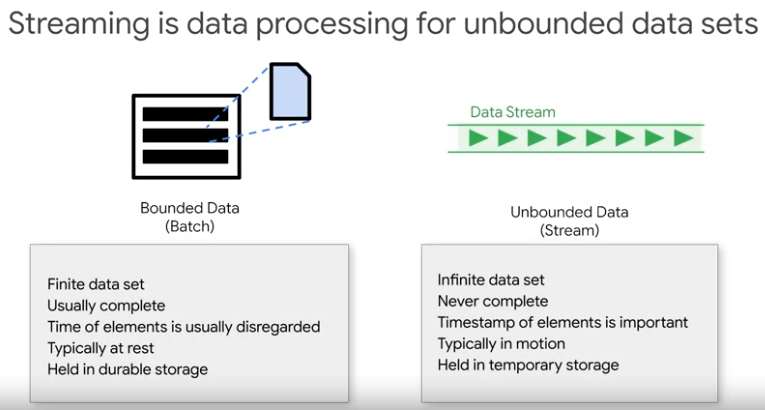

- Streaming is data processing on unbounded data, which is data not at rest. Stream processing is how you deal with this unbounded data. A streaming processing engine provides low latency, speculative or partial results, the ability to flexibly reason about time, controls for correctness, and the power to perform complex analysis.

- Challenges associated with streaming processes

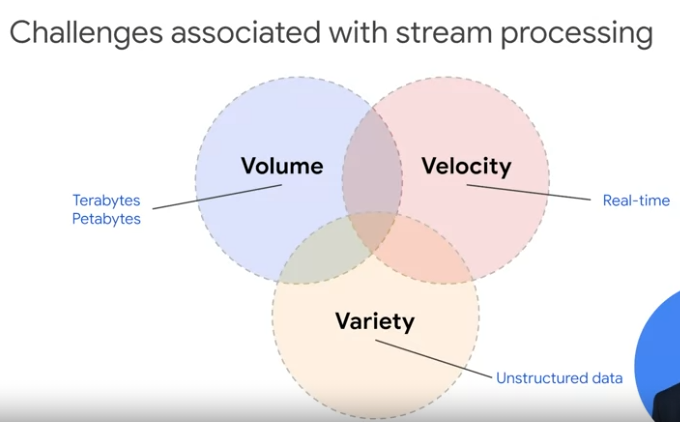

- The three big products we are going to consider here are Cloud Pub/Sub, which will allow us to handle changing volumes of data, Cloud Dataflow, which can assist in processing data without undue delays, and BigQuery, which we will use for our ad-hoc reporting, even on streaming data.

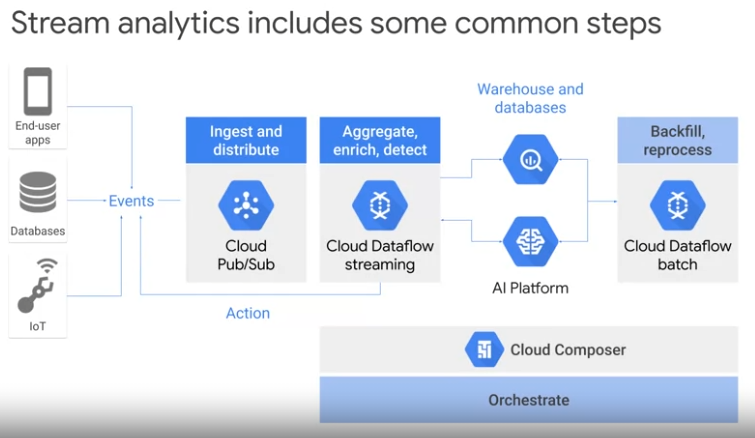

- Cloud Pub/Sub

- Cloud Pub/Sub provides an asynchronous messaging bus, which can hold these events until they are consumed by respective services for further processing. You can use Cloud Pub/Sub to connect applications within Google Cloud, and with applications on-premise, or in other Clouds to create Hybrid Data Engineering solutions with Cloud Pub/Sub, the applications do not need to be online and available all the time. The parts don't need to know how to communicate to each other, just to Cloud Pub/Sub, which can help simplify system design. A good example is the email scenario, where sender and receiver do not need to be available at the same time, but the message still goes through, and the receiver ultimately we'll get to consume it when it's ready to receive it. 

- By default, it will save your messages for up to seven days. In the event your systems are down and not able to process them at the time, you may retrieve messages at a later time, and continue with your processing.

- The Cloud Pub/Sub Client that creates the topic is called the publisher, and the Cloud Pub/Sub Client that creates the subscription is called the subscriber. Publisher will publish events and messages into a topic to be distributed and used for further processing. To receive messages published to a topic, you must create a subscription to that topic.

- Only messages published to the topic after the subscription is created are available to subscriber applications.

- A topic can have multiple subscriptions, but a given subscription belongs to a single topic.



- Cloud Publish/Subscribe patterns (different colors mean different messages)

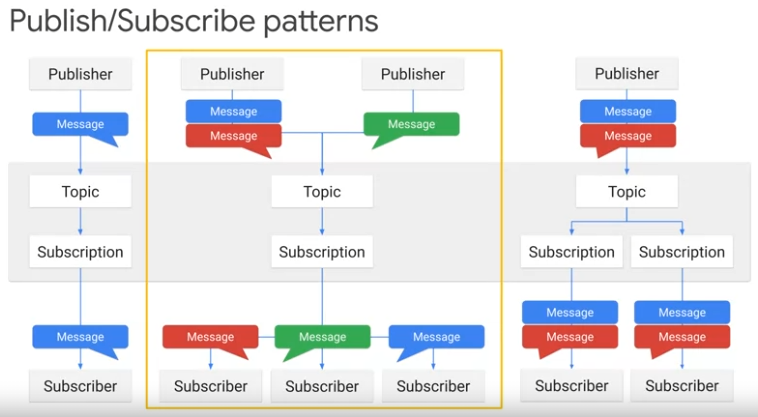

- Cloud Pub/Sub subscription allows for both push and pull delivery

- In the pull model, your clients are subscribers and will be periodically calling for messages, and Pub/Sub will just be delivering the messages since the last call.

- Pull call --> Message is sent --> subscriber send reciept acknowledgment

- you don't want to acknowledge the message until you firmly have the message and have done the processing on it. Otherwise, you might lose the message if the system goes down. Therefore, we generally recommend you wait to acknowledge until after you have received it.

- 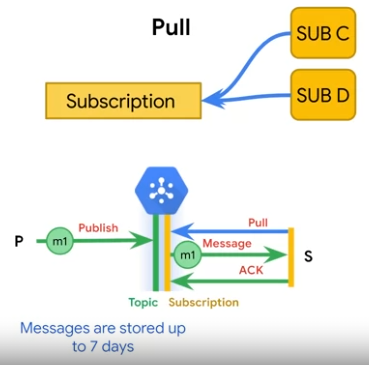

- In push delivery, Cloud Pub/Sub initiates requests to your subscriber application, to deliver messages. The Cloud Pub/Sub servers sends each message as an HTTPS request to the subscriber application at a preconfigured endpoint. In the push scenario, you just respond with status 200 Okay for the HTTP call, and that tells Pub/Sub the message delivery was successful.

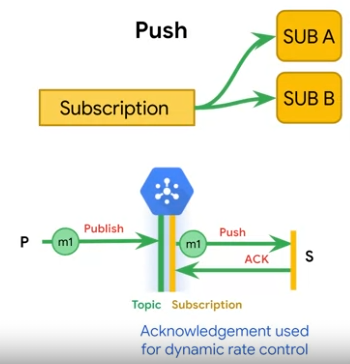

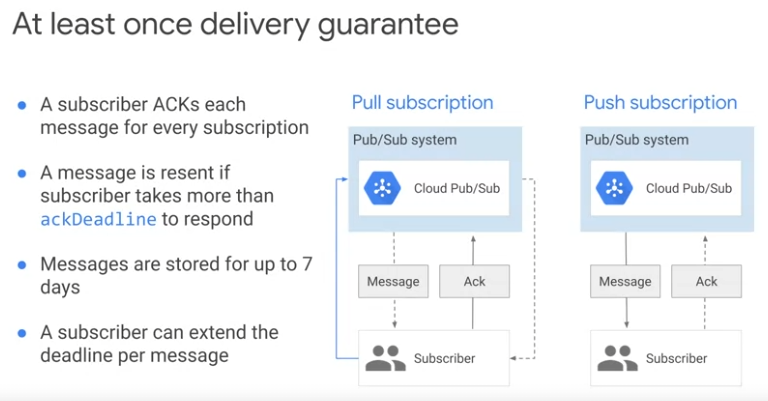

- Creating topic and publishing with cloud pub/sub

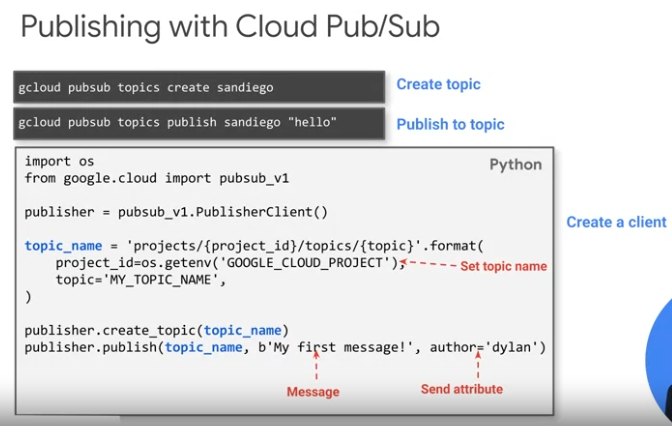

-Notice the b right here in front of my-first message. This is because PubSub just sends raw bytes. This means that you aren't restricted to just texts. You can send other data like images if you wanted to. The limit is 10 megabytes.

- There are also extra attributes that you can include in messages. In this example, you see author equals dylan. PubSub will keep track of those attributes to allow your downstream systems to get metadata about your messages without having to put it all in the message and pass it out. So instead of serializing and deserializing, it will just keep track of those key value pairs. 

- Subscribing with Cloud Pub/Sub using async pull

- Using asynchronous pulling provides higher throughput in your application by not requiring your application to block for new messages. Messages can be received in your application using a long-running message listener and acknowledge one message at a time as shown in the example here.

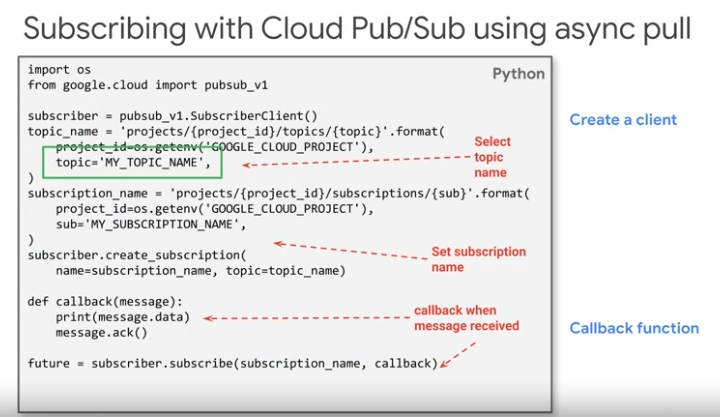

- Subscribing with Cloud Pub/Sub using synchronous pull

- Use when you need a precise cap on the number of messages retrieved by client at any given time.

- By default, it will just churn one message, the latest message. But there is a limit option you can set. Maybe you want 10 messages at a time. 

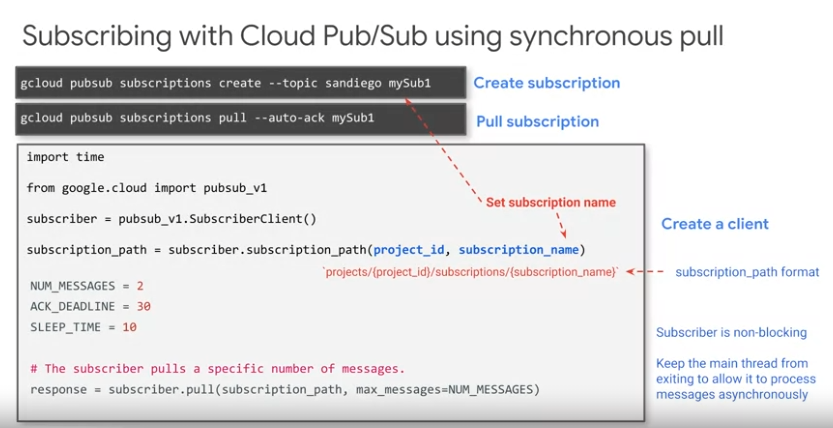

- By default, the publisher will batch publish messages. This prevents the overhead of the call for individual messages on the publisher side. This allows the publisher to wait and send 10 or 50 at a time. This increases efficiency. However, if you are waiting for 50 messages, this means that the first one now has some latency associated with it. So it's a trade-off in your system. 

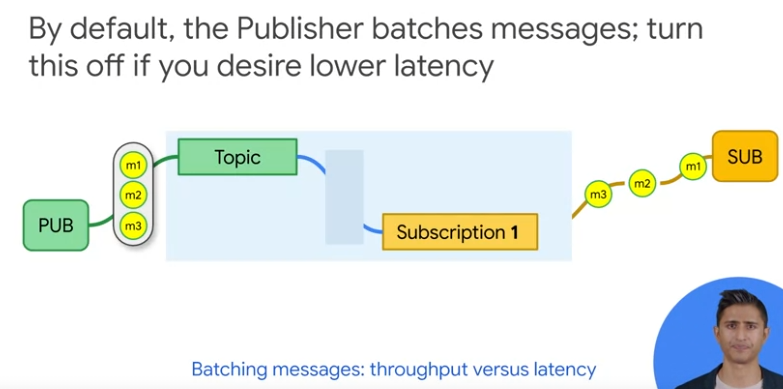

- using python to change the batch settings in cloud pub/sub

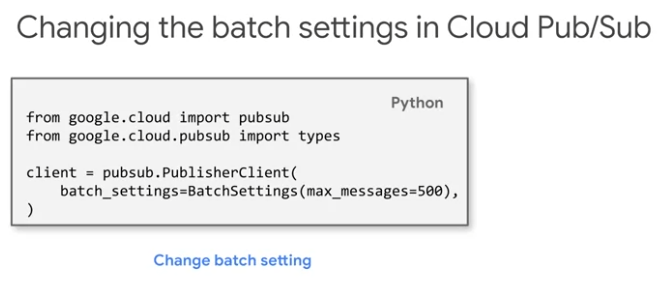

When working with Pub/Sub there are few things to keep in mind. First, data may be delivered out of order, but that doesn't mean you have to process the data that way. You could write an application that handles out of order and replicated messages. This is different from a true queuing system. In general, they will be delivered in order but you can't rely on that with Pub/Sub.

- a message might take another route, and if it happens to be a slower route, you could have an earlier message arriving later. For example, you wouldn't use this to implement a chat application because it would be awkward when messages arrive out of order.

- Use cloud dataflow with cloud pub/sub to mitigate these issues

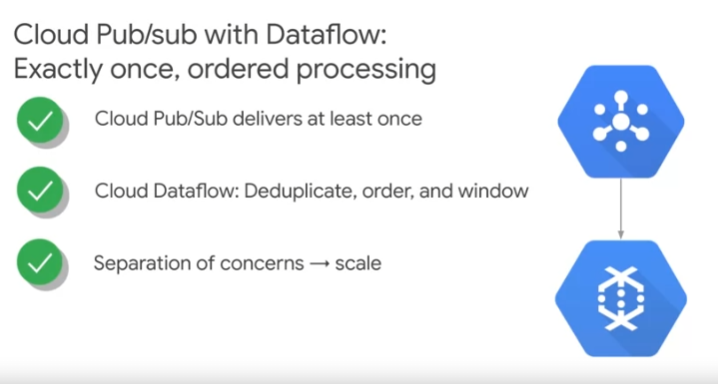

Lab: 
- start vm machine
- 

In [ ]:
 Copyright 2018 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import time
import gzip
import logging
import argparse
import datetime
from google.cloud import pubsub

TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
TOPIC = 'sandiego'
INPUT = 'sensor_obs2008.csv.gz'

def publish(publisher, topic, events):
   numobs = len(events)
   if numobs > 0:
       logging.info('Publishing {0} events from {1}'.format(numobs, get_timestamp(events[0])))
       for event_data in events:
         publisher.publish(topic,event_data)

def get_timestamp(line):
   ## convert from bytes to str
   line = line.decode('utf-8')

   # look at first field of row
   timestamp = line.split(',')[0]
   return datetime.datetime.strptime(timestamp, TIME_FORMAT)

def simulate(topic, ifp, firstObsTime, programStart, speedFactor):
   # sleep computation
   def compute_sleep_secs(obs_time):
        time_elapsed = (datetime.datetime.utcnow() - programStart).seconds
        sim_time_elapsed = ((obs_time - firstObsTime).days * 86400.0 + (obs_time - firstObsTime).seconds) / speedFactor
        to_sleep_secs = sim_time_elapsed - time_elapsed
        return to_sleep_secs

   topublish = list() 

   for line in ifp:
       event_data = line   # entire line of input CSV is the message
       obs_time = get_timestamp(line) # from first column

       # how much time should we sleep?
       if compute_sleep_secs(obs_time) > 1:
         # notify the accumulated topublish
          publish(publisher, topic, topublish) # notify accumulated messages
          topublish = list() # empty out list

          # recompute sleep, since notification takes a while
          to_sleep_secs = compute_sleep_secs(obs_time)
          if to_sleep_secs > 0:
             logging.info('Sleeping {} seconds'.format(to_sleep_secs))
             time.sleep(to_sleep_secs)
       topublish.append(event_data)

   # left-over records; notify again
   publish(publisher, topic, topublish)

def peek_timestamp(ifp):
   # peek ahead to next line, get timestamp and go back
   pos = ifp.tell()
   line = ifp.readline()
   ifp.seek(pos)
   return get_timestamp(line)


if __name__ == '__main__':
   parser = argparse.ArgumentParser(description='Send sensor data to Cloud Pub/Sub in small groups, simulating real-time behavior')
   parser.add_argument('--speedFactor', help='Example: 60 implies 1 hour of data sent to Cloud Pub/Sub in 1 minute', required=True, type=f$
   parser.add_argument('--project', help='Example: --project $DEVSHELL_PROJECT_ID', required=True)
   args = parser.parse_args()

   # create Pub/Sub notification topic
   logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)
   publisher = pubsub.PublisherClient()
   event_type = publisher.topic_path(args.project,TOPIC)
   try:
      publisher.get_topic(event_type)
      logging.info('Reusing pub/sub topic {}'.format(TOPIC))
   except:
      publisher.create_topic(event_type)
      logging.info('Creating pub/sub topic {}'.format(TOPIC))

   # notify about each line in the input file
   programStartTime = datetime.datetime.utcnow() 
   with gzip.open(INPUT, 'rb') as ifp:
      header = ifp.readline()  # skip header
      firstObsTime = peek_timestamp(ifp)
      logging.info('Sending sensor data from {}'.format(firstObsTime))
      simulate(event_type, ifp, firstObsTime, programStartTime, args.speedFactor)

- Cloud data flow can be used for processing streaming and batch pipelines
- Challenges with processing streaming data

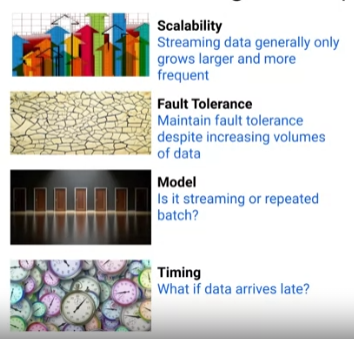

- Cloud data flow has three types of windows to process streaming data
 - Fixed (non-overlaping time-based: hourly, monthly etc.)
 - Sliding (Can over lap: For example, give me five minutes worth of data and compute that every 30 minutes)
 - Session (timing is trigerred by another element such as when a user opens a web page)

 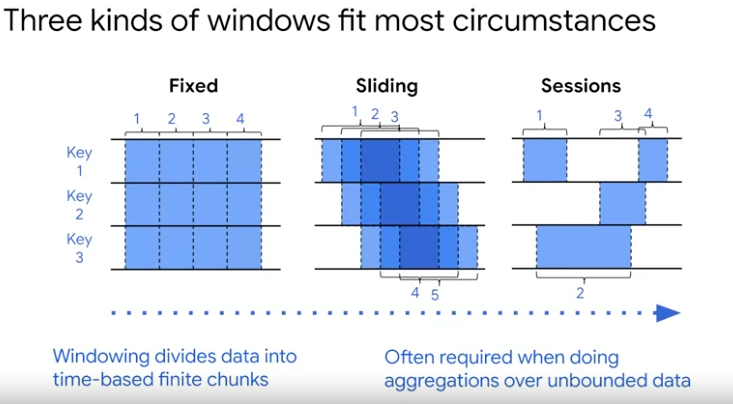

- Session windows are for situations where the communication is bursty. It might correspond to a web session. An example might be if a user comes in and uses four to five pages and leaves. You can capture that as a session window. 

- Here is how we can set these different types of Windows in Python.

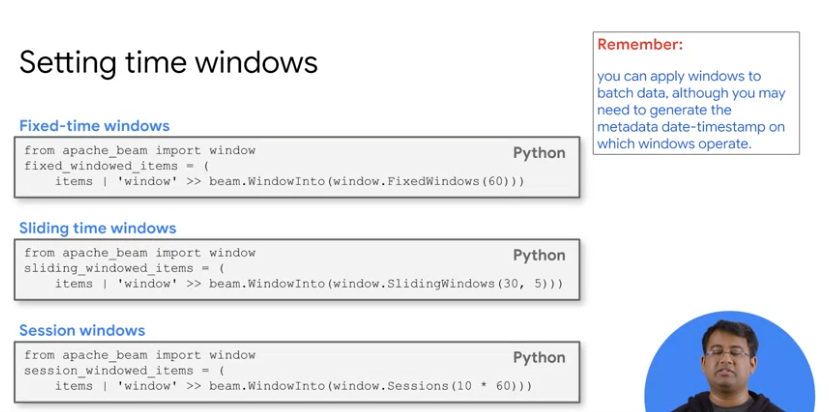

- How should Cloud Dataflow handle latency (data recieved after expected time window)

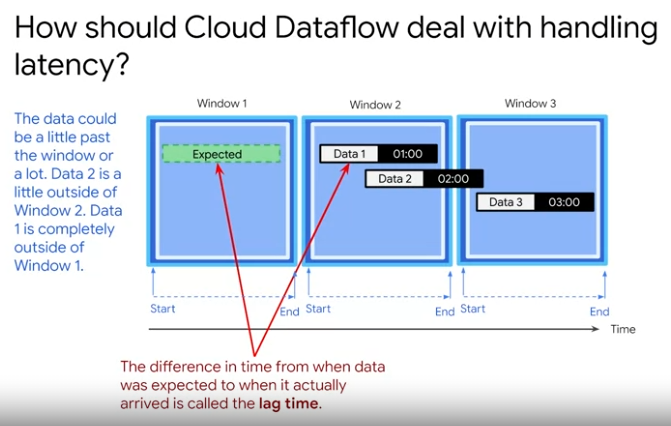

-Data flow can automatically keeps track of this lag time with a technique known as watermark.

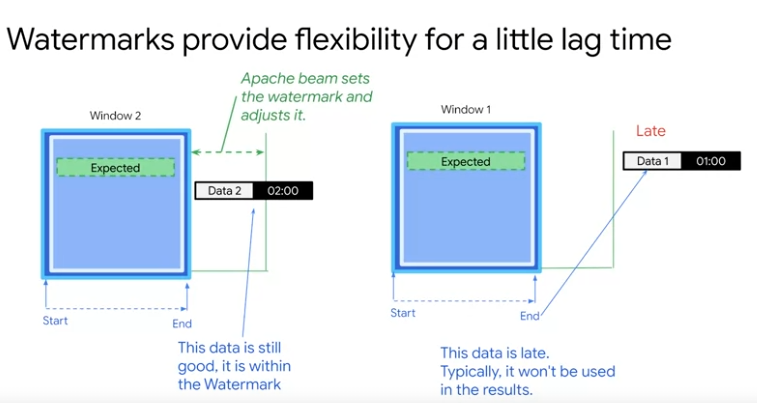

-Processing time triggers operate on the time at which an element is processed at some point in the pipeline as data mined by a system clock. You could set an after processing time trigger on unbounded data contained in a global window. For example, emitting data every 30 seconds, the data never ends, the window never closes. But interim results are emitted every 30 seconds by the trigger. And a data-driven trigger is associated with the condition of data contained in the element itself. Currently, this simply counts each element that has been processed in the window. You could set after count to 15, and every 15 elements processed would cause an emit. Composite triggers combine effects. For example, consider if you had a data-driven after count trigger set to 15. Every 15 elements, it would emit. However, if there are 14 elements in the P-collection and no more data arrived, the 14 would sit in the window forever. In this case, you could add in an event time trigger to ensure that the last 14 were serviced by an emit.

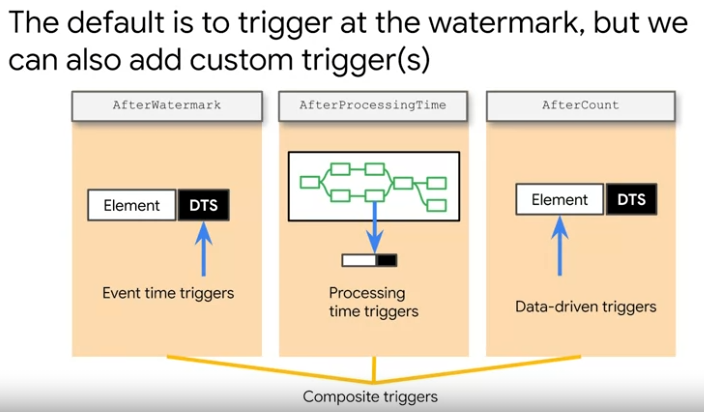

- Example triggers code

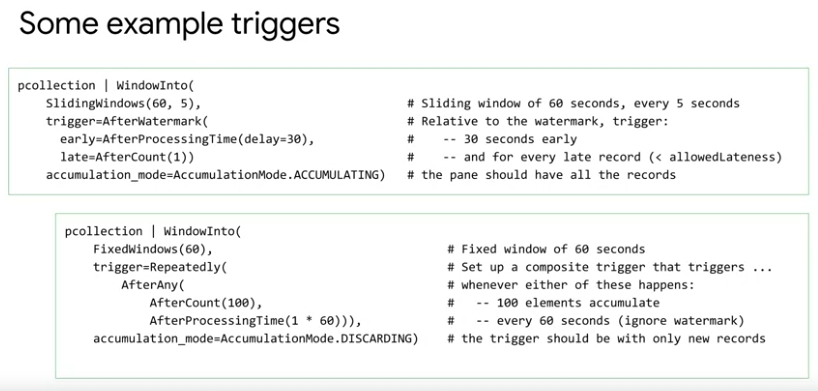

Lab: Streaming Data Processing: Streaming Data Pipelines

- from VM CLI, type:

  - git clone https://github.com/GoogleCloudPlatform/training-data-analyst

  - 
